## Deep Q-Learning Agent

Code is based on and partly copied from these two sources: 
- https://arshren.medium.com/deep-q-learning-a-deep-reinforcement-learning-algorithm-f1366cf1b53d
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

NOTE: Do not forget to change this notebook into a .py file before submission. Also, save and load the model after it has been trained.

In [22]:
# importing required libraries
# import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display

In [23]:
import os
cwd = os.getcwd()
cwd
new_path = cwd[:-7]
new_path

'c:\\Users\\20174216\\OneDrive - TU Eindhoven\\Documents\\1. TUe MSc DSAI\\Q4\\2AMC15 - Data Intelligence Challenge\\2AMC15-2'

In [24]:
os.chdir('c:\\Users\\20174216\\OneDrive - TU Eindhoven\\Documents\\1. TUe MSc DSAI\\Q4\\2AMC15 - Data Intelligence Challenge\\2AMC15-2023-DIC')

In [25]:
#TODO: Fix the imports below, since they are required for the notebook to function.

from world import Environment
from world import Grid
from world import agent_vision

from pathlib import Path

In [26]:
plt.ion()

# setting the device
# if gpu is to be used for Mac OS
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# if gpu is to be used for cuda

#device = torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [27]:
# structure of the Experiences to store
Experience = namedtuple('Experience', 
('state', 'action', 'next_state', 'reward'))

# stores the Experience Replay buffer
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        # Save the Experience into memory 
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        #selecting a random batch of Experience for training
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

In [28]:
#TODO: Change the model to a CNN so that it can work with the agent vision input?

"""Simple MLP network."""
class DQN(nn.Module):
    """
        Args:
            n_observations: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
    def __init__(self, n_vision, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_vision, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, n_actions)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = F.relu(self.layer4(x))
        x = self.dropout(x)
        return self.layer5(x)

In [29]:
BATCH_SIZE = 64      # BATCH_SIZE is the number of Experiences sampled from the replay buffer
GAMMA = 0.99          # GAMMA is the discount factor as mentioned in the previous section
EPSILON_START = 0.9   # EPSILON_START is the starting value of epsilon
EPSILON_END = 0.05    # EPSILON_END is the final value of epsilon
EPSILON_DECAY = 40000  # EPSILON_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 5e-3           # TAU is the update rate of the target network
LR = 1e-4             # LR is the learning rate of the AdamW optimizer
HIDDEN_SIZE = 128     # the hidden layers in the DQN

In [30]:
env = Environment(
    grid_fp=Path('grid_configs/simple.grd'),
    n_agents=1,
    agent_start_pos=None,
    sigma=0.0,
    no_gui=True,
    # target_fps=fps,
    # random_seed=0,
    reward_fn='custom',
)

obs, info = env.get_observation()

print(obs, info)

[[1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 0 0 3 0 1]
 [1 3 0 2 0 0 1]
 [1 0 0 2 0 0 1]
 [1 0 0 2 0 4 1]
 [1 1 1 1 1 1 1]] {'dirt_cleaned': [0], 'agent_moved': [False], 'agent_charging': [False], 'agent_pos': [(4, 1)], 'agent_pos_arr': [array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int8)], 'dirt_vecs': [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]}


c:\Users\20174216\OneDrive - TU Eindhoven\Documents\1. TUe MSc DSAI\Q4\2AMC15 - Data Intelligence Challenge\2AMC15-2023-DIC\world\environment.py:194: UserWarning: No initial agent positions given. Randomly placing agents on the grid.
  warn(


In [31]:
def choose_action(state, policy_network):
    global steps_done
    sample = random.random()
    global epsilon_threshold
    epsilon_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)
    # epsilon_threshold = 0.5
    # print(state)
    # print(state.shape)
    steps_done += 1
    if sample > epsilon_threshold:
        # max(1) will return largest column value of each row.
        # second column on max result is index of where max element was found
        # so we pick action with the larger expected reward.
        with torch.no_grad():
            return torch.tensor([torch.argmax(policy_network(state))])
    else:
        return torch.tensor([random.randint(0,3)], device=device, dtype=torch.long)

In [32]:
def plot_scores(show_result=False):
    '''
    Function to plot the durations of episodes, 
    along with an average over the last 100 episodes
    '''
    plt.figure(1)
    duration_t = torch.tensor(episode_duration, dtype= torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_t.numpy())
    # Take 100 episode averages and plot them too
    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
    else:
            display.display(plt.gcf())

In [33]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transition = memory.sample(BATCH_SIZE)
    
    '''
    # Transpose the batch and convert the  batch-array of Experience
    # to Transition of batch-arrays
    '''
    batch = Experience(*zip(*transition))
    #print('batch:', batch)
    #Compute a mask of non-final states and concatenate the batch element
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.stack(batch.state)
    # print('state batch:', state_batch, len(state_batch))
    action_batch = torch.stack(batch.action)
    # print('action batch:', action_batch, len(action_batch))
    reward_batch = torch.stack(batch.reward)
    # print('reward batch:', reward_batch)

    
    # Compute Q(s_t, a)
    # These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_network(state_batch) #.gather(0, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    next_state_values = torch.zeros((BATCH_SIZE,4),device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = reward_batch + (GAMMA* next_state_values)
    
    # Compute Huber loss
    criterion=nn.SmoothL1Loss()
    loss=criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    #optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

In [44]:
#function that performs a single step of the optimization
def optimize_model_2():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch and convert the  batch-array of Experience
    # to Transition of batch-arrays
    batch = Experience(*zip(*transitions))

    #Compute a mask of non-final states and concatenate the batch element
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    global state_batch
    state_batch = torch.stack(batch.state)
    # print('state batch:', state_batch, len(state_batch))
    global action_batch
    action_batch = torch.stack(batch.action)
    # print('action batch:', action_batch, len(action_batch))
    global reward_batch
    reward_batch = torch.stack(batch.reward)
    # print('reward batch:', reward_batch)

    
    # Compute Q(s_t, a)
    # These are the actions which would've been taken
    # for each batch state according to policy_net

    # Reshape tensor2 to have the same number of dimensions as tensor1
    action_batch_reshaped = action_batch.unsqueeze(-1)  # Add an extra dimension at the end
    # Apply torch.gather
    state_action_values = torch.gather(policy_network(state_batch), dim=2, index=action_batch_reshaped)
    state_action_values = state_action_values.squeeze(-1)  # Remove the last dimension

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    next_state_values = torch.zeros((BATCH_SIZE,4),device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0]
        global next_state_valuesss
        next_state_values = next_state_values.max(1)[0]
        next_state_valuesss = next_state_values

    # Compute the expected Q values
    expected_state_action_values = reward_batch + (GAMMA* next_state_values)
    
    criterion = nn.MSELoss()
    # print('Expected state action values:', expected_state_action_values.shape, 'State action values:', state_action_values.shape)
    loss = criterion(state_action_values.unsqueeze(1), expected_state_action_values.unsqueeze(1))
    # print('Loss:', loss)
    
    #optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

In [45]:
env.reset()
obs, info = env.get_observation()
#print(obs)
#print(info)

agent_pos = info['agent_pos']
agent_pos_arr = np.array(info['agent_pos_arr'])
dirt_vecs = np.array(info['dirt_vecs'])

g = Grid(obs.shape[0], obs.shape[1])
g.cells = obs
#print(agent_pos)
agent_view = agent_vision(loc=agent_pos[0], grid=g, vis_range=2)

print(agent_view)
print(agent_pos_arr)
print(dirt_vecs)

agent_view = torch.flatten(torch.from_numpy(agent_view))
agent_pos_arr = torch.flatten(torch.from_numpy(agent_pos_arr))
dirt_vecs = torch.flatten(torch.from_numpy(dirt_vecs))
agent_input = torch.cat((agent_view, agent_pos_arr, dirt_vecs)).unsqueeze(0)

# print(agent_input)

[[-1 -1  2 -1 -1]
 [-1  0  0  0 -1]
 [ 2  0  0  0  0]
 [-1  3  0  2 -1]
 [-1 -1  0 -1 -1]]
[[[0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [46]:
def agent_input(obs, info, vis_range):
    # print('Info in agent input function:', info)
    agent_pos = info['agent_pos']
    g = Grid(obs.shape[0], obs.shape[1])
    g.cells = obs

    agent_view = agent_vision(loc=agent_pos[0], grid=g, vis_range=vis_range)
    agent_view = torch.flatten(torch.from_numpy(agent_view))

    agent_pos_arr = torch.tensor(np.vstack(info['agent_pos_arr']).astype(float))
    agent_pos_arr = torch.flatten(agent_pos_arr)

    dirt_vecs = torch.FloatTensor(np.array(info['dirt_vecs']))
    dirt_vecs = torch.flatten(dirt_vecs)

    return torch.cat((agent_view, agent_pos_arr, dirt_vecs)).unsqueeze(0)

In [47]:
# # Code to check if the model has exploding gradients
# def check_grad(model):
#     for p in model.parameters():
#         if p.grad is not None:
#             print(p.grad.data.sum())

# check_grad(policy_network)

In [48]:
import time


n_actions = 4
vis_range = 2
n_input = 104
max_steps = 1000

env.reset(no_gui=True)
obs, info = env.get_observation()
agent_pos = info['agent_pos']

# g = Grid(obs.shape[0], obs.shape[1])
# g.cells = obs

# print(info['dirt_vecs'])
state = agent_input(obs, info, vis_range).to(device)
# print(state)
# n_input = len(state)

policy_network = DQN(n_input, n_actions, HIDDEN_SIZE).to(device)
target_network = DQN(n_input, n_actions, HIDDEN_SIZE).to(device)
#updates the parameters of the target network  with the parameters of the policy network 
target_network.load_state_dict(policy_network.state_dict())

optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)    # Set the memory capacity here
steps_done = 0

episode_duration = []
episode_reward = []
episode_epsilon = []

if torch.cuda.is_available():
    num_episodes = 100
    print(f'CUDA is available. Running on GPU for {num_episodes} episodes.\n              ====================\n')
else:
    num_episodes = 1
    print('CUDA is not available. Running on CPU {num_episodes} episodes.')

for i in range(num_episodes):
    # print(f'EPISODE {i}\n----------')
    #At the beginning we reset the environment and 
    #initialize the state Tensor.
    env.reset(no_gui=True)  #, target_fps=1)
    obs, info = env.get_observation()
    agent_pos = info['agent_pos']
    #g = Grid(obs.shape[0], obs.shape[1])
    #g.cells = obs

    state = agent_input(obs, info, vis_range).to(device).float()
    # print('Initial state shape:', state.shape)
    total_reward = 0

    for t in range(max_steps):
        # Sample an action
        # print(f'----------\nLOOP {t}\n----------')
        # print('State shape:', state.shape)
        action = choose_action(state, policy_network).to(device)
        # Execute it, observe the next state and the reward
        next_obs, reward, terminated, next_info = env.step([action])
        reward = torch.tensor([reward], device=device, dtype=torch.long)
        total_reward += reward

        _, next_info = env.get_observation()
        # print('next_info:', next_info)
        
        # print('next_obs', next_obs.shape)
        # print('next_info', next_info)
        if terminated:
            episode_duration.append(t + 1)
            print("Episode", i,"Game terminated after", t, "steps with reward", np.array(total_reward.cpu())[0])
            break
        else:
            next_state = agent_input(next_obs, next_info, vis_range).to(device).float()

        # Store the experience in the memory
        memory.push(state, action, next_state, reward)
        # print(state, action, next_state, reward)
        # Move to the next state and grid
        state = next_state
        obs = next_obs
        # print(state)
        
        # Perform one step of the optimization (on the policy network)
        # The agent performs an optimization step on the Policy Network using the stored memory
        optimize_model_2()

        # Update target network every 100 steps
        if t//100 == 0:
            target_net_state_dict = target_network.state_dict()
            policy_net_state_dict = policy_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        # target_net_state_dict = target_network.state_dict()
        # policy_net_state_dict = policy_network.state_dict()
        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[key] #*TAU + target_net_state_dict[key]*(1-TAU)
        # target_network.load_state_dict(target_net_state_dict)

    
    # print('Total Reward:', np.array(total_reward.cpu())[0], '\n')

    episode_reward.append(np.array(total_reward.cpu())[0])
    episode_duration.append(np.array(t + 1))
    episode_epsilon.append(np.array(epsilon_threshold))
        
print('Complete')
# plot_scores(show_result=True)
# plt.ioff()
# plt.show()

Episode 4 Game terminated after 432 steps with reward -410
Episode 5 Game terminated after 444 steps with reward -422
Episode 6 Game terminated after 347 steps with reward -325
Episode 7 Game terminated after 489 steps with reward -467
Episode 8 Game terminated after 510 steps with reward -488
Episode 9 Game terminated after 259 steps with reward -237
Episode 10 Game terminated after 87 steps with reward -65
Episode 11 Game terminated after 47 steps with reward -25
Episode 12 Game terminated after 112 steps with reward -90
Episode 13 Game terminated after 93 steps with reward -71
Episode 14 Game terminated after 404 steps with reward -382
Episode 15 Game terminated after 226 steps with reward -204
Episode 16 Game terminated after 150 steps with reward -128
Episode 17 Game terminated after 279 steps with reward -257
Episode 18 Game terminated after 739 steps with reward -717
Episode 19 Game terminated after 380 steps with reward -358
Episode 20 Game terminated after 96 steps with reward

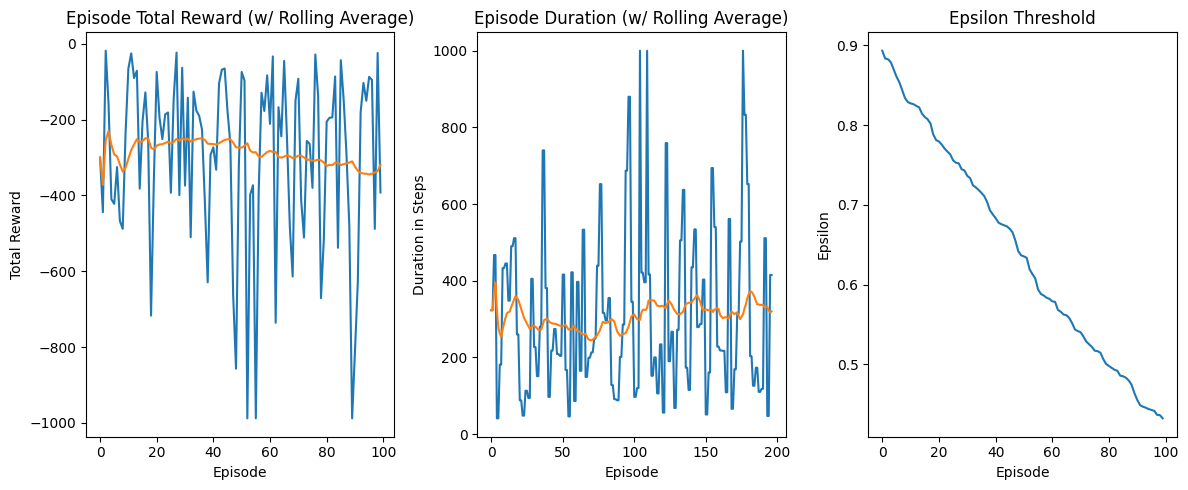

In [49]:
# Plot the episode total reward, epsiode duration and epsilon threshold per episode

# Calculate rolling average of the total reward per episode
avg_total_reward = []
window = 50
for i in range(len(episode_reward)):
    if i < window:
        avg_total_reward.append(np.mean(episode_reward[:i+1]))
    else:
        avg_total_reward.append(np.mean(episode_reward[i-window:i]))

# Calculate rolling average of the duration per episode
avg_duration = []
window = 50
for i in range(len(episode_duration)):
    if i < window:
        avg_duration.append(np.mean(episode_duration[:i+1]))
    else:
        avg_duration.append(np.mean(episode_duration[i-window:i]))

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.plot(episode_reward)
plt.plot(avg_total_reward)
plt.title('Episode Total Reward (w/ Rolling Average)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(132)
plt.plot(episode_duration)
plt.plot(avg_duration)
plt.title('Episode Duration (w/ Rolling Average)')
plt.xlabel('Episode')
plt.ylabel('Duration in Steps')
plt.subplot(133)
plt.plot(episode_epsilon)
plt.title('Epsilon Threshold')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.tight_layout()

plt.show()

In [50]:
# write code for testing the agent's performance on the simple grid
EPSILON = 0

target_network.eval()
env.reset(no_gui=False, target_fps=1)
obs, info = env.get_observation()
agent_pos = info['agent_pos']
#g = Grid(obs.shape[0], obs.shape[1])
#g.cells = obs

state = agent_input(obs, info, vis_range).to(device).float()
total_reward = 0

for t in range(max_steps):
    # Sample an action
    with torch.no_grad():
        action = torch.tensor([torch.argmax(policy_network(state))])
    # Execute it, observe the next state and the reward
    next_obs, reward, terminated, next_info = env.step([action])
    reward = torch.tensor([reward], device=device, dtype=torch.long)

    _, next_info = env.get_observation()

    if terminated:
        break
    else:
        next_state = agent_input(next_obs, next_info, vis_range).to(device).float()

    # Store the experience in the memory
    memory.push(state, action, next_state, reward)
    # Move to the next state and grid
    state = next_state
    obs = next_obs
    total_reward += reward

    if terminated:
        print("Game terminated after", t, "steps with reward", total_reward)
        break

print('Total Reward:', total_reward[0], '\n')

KeyboardInterrupt: 

In [ ]:
action_batch

In [ ]:
reward_batch

In [ ]:
next_state_valuesss

In [ ]:
Q_values = policy_network(state_batch)
Q_values

tensor([[[-2.5479, -2.5548, -2.6423, -2.4535]],

        [[-2.6809, -2.9433, -2.6759, -2.6537]],

        [[-3.4899, -3.1987, -3.0294, -3.3307]],

        [[-2.8427, -3.2493, -3.6374, -3.1234]],

        [[-3.4113, -3.0783, -3.0060, -3.1247]],

        [[-3.7396, -3.5309, -3.3807, -3.1611]],

        [[-3.6289, -3.3865, -3.7313, -3.6668]],

        [[-3.0569, -3.3489, -3.7424, -2.8718]],

        [[-3.3008, -2.9607, -2.7943, -3.1291]],

        [[-3.7801, -3.5720, -4.0023, -3.6019]],

        [[-4.0604, -4.0918, -4.1505, -4.1948]],

        [[-3.6535, -3.0933, -3.6326, -3.7864]],

        [[-3.3469, -3.7709, -3.5866, -3.6189]],

        [[-3.4903, -3.1248, -3.5635, -3.0199]],

        [[-3.3102, -2.9596, -3.2141, -3.5405]],

        [[-3.3362, -3.8186, -3.3306, -3.7554]],

        [[-3.2714, -3.2318, -3.1092, -2.7678]],

        [[-3.3293, -3.7733, -3.3061, -3.3860]],

        [[-3.8424, -3.2851, -3.5855, -3.6015]],

        [[-3.7229, -3.8281, -3.4145, -3.3672]],

        [[-3.5433, -

In [ ]:
action_batch.shape

In [ ]:
# Write code for using torch.gather on the Q-values tensor to get the Q-values for the actions taken in the batch
import torch

# Assuming tensor1.shape = torch.Size([64, 1, 4]) and tensor2.shape = torch.Size([64, 1])
tensor1 = Q_values
tensor2 = action_batch

# Reshape tensor2 to have the same number of dimensions as tensor1
tensor2_reshaped = tensor2.unsqueeze(-1)  # Add an extra dimension at the end

# Apply torch.gather
output = torch.gather(tensor1, dim=2, index=tensor2_reshaped)

# The output tensor will have the shape torch.Size([64, 1, 1])

# If you want to remove the extra dimension, you can squeeze the tensor
output_squeezed = output.squeeze(-1)  # Remove the last dimension

# The output_squeezed tensor will have the shape torch.Size([64, 1])

output_squeezed
